## Initial Data Cleaning ##

Collects and unifies primary and secondary school data where the anonymized student is present in both.

In [1]:
import csv
import os
import pandas as pd
import numpy as np

In [2]:
# Check files in the Raw Data folder
os.listdir('../Data/Raw')

['Avaluacio_de_quart_dEducació_Secundaria_Obligatoria_20251111.csv',
 'Avaluació_de_sise_deducació_primaria_20251110.csv',
 'Plantilles_del_personal_docent_dels_centres_públics_i_serveis_educatius_20251111.csv']

In [3]:
#csv_path = os.path.abspath("../Data/Raw/Avaluacio_de_quart_dEducació_Secundaria_Obligatoria_20251111.csv")

# GENERAL OPTION: Take the first file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()
df_S = pd.DataFrame(secondary_data)

# Second file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])
primary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()
df_P = pd.DataFrame(primary_data)

In [4]:
df_P.columns = df_P.iloc[0]    # set first row as header
df_P = df_P[1:]                # drop the first row (since it's now the header)
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]    # set first row as header
df_S = df_S[1:]                # drop the first row (since it's now the header)
df_S.reset_index(drop=True, inplace=True)

In [5]:
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE']) 
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']] 

# Keep only rows from df_P where CODI_ALUMNE exists in both
df_P_matching = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
# Keep only rows from df_S where CODI_ALUMNE exists in both
df_S_matching = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P_matching.reset_index(drop=True, inplace=True)
df_S_matching.reset_index(drop=True, inplace=True)

In [6]:
common_cols = set(df_P_matching.columns) & set(df_S_matching.columns)

In [7]:
print(df_P.columns)
print(df_S.columns)

Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO',
       'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE',
       'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3',
       'GENERE', 'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'AREA_TERRITORIAL',
       'NATURALESA', 'HÀBITAT'],
      dtype='object', name=0)
Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PANG', 'PANG_CO', 'PANG_CL', 'PANG_EE', 'PFRAN',
       'PFRAN_CO', 'PFRAN_CL', 'PFRAN_EE', 'PMAT', 'PMAT_EFM', 'PMAT_CR',
       'PMAT_EST', 'PMAT_NC', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN',
       'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4', 'GENERE',
       'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'NATURALESA', 'ÀREA TERRITORIAL',
       'HÀBITAT'],
      dtype='object', name=0)


In [8]:
# List of required columns (from your message)
required_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'GENERE', 'HÀBITAT',
    'MES_NAIXEMENT', 'NATURALESA', 'PANG', 'PANG_CO', 'PANG_EE',
    'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE',
    'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC'
]

df_P_clean = df_P.dropna(subset=required_cols).copy()
df_S_clean = df_S.dropna(subset=required_cols).copy()

common_ids = set(df_P_clean['CODI_ALUMNE']) & set(df_S_clean['CODI_ALUMNE'])
df_P_clean = df_P_clean[df_P_clean['CODI_ALUMNE'].isin(common_ids)]
df_S_clean = df_S_clean[df_S_clean['CODI_ALUMNE'].isin(common_ids)]

df_P_clean['snapshot'] = 'past'
df_S_clean['snapshot'] = 'present'

df_combined = pd.concat([df_P_clean, df_S_clean], ignore_index=True)

df_pivot = df_combined.pivot_table(
    index='CODI_ALUMNE',
    columns='snapshot',
    values=[col for col in required_cols if col != 'CODI_ALUMNE'],
    aggfunc='first'
)

In [9]:
df_pivot

0             ANY         ANY_NAIXEMENT         GENERE          \
snapshot     past present          past present   past present   
CODI_ALUMNE                                                      
             2018    2019          2005              H       D   
100028145    2018    2022          2005    2005      D       D   
1000332771   2016    2020          2004    2004      H       H   
1000343103   2016    2020          2004    2004      D       D   
1000354325   2016    2020          2004    2004      D       D   
...           ...     ...           ...     ...    ...     ...   
999005478    2016    2020          2004    2004      H       H   
999027032    2016    2020          2004    2004      H       H   
99949376     2016    2020          2004    2004      D       D   
99961597     2019    2023          2007    2007      H       H   
99983150     2018    2022          2006    2006      D       D   

0                      HÀBITAT                    MES_NAIXEMENT          ...  \
snapshot                  past            present          past present  ...   
CODI_ALUMNE                                                              ...   
                 Més de 100000      Més de 100000             1          ...   
100028145        Més de 100000      Més de 100000             7       7  ...   
1000332771   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000343103   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000354325   De 10001 a 100000  De 10001 a 100000            10      10  ...   
...                        ...                ...           ...     ...  ...   
999005478    De 10001 a 100000  De 10001 a 100000            11      11  ...   
999027032    De 10001 a 100000  De 10001 a 100000             9       9  ...   
99949376         Més de 100000      Més de 100000             7       7  ...   
99961597         Més de 100000      Més de 100000             7       7  ...   
99983150         Més de 100000      Més de 100000            10      10  ...   

0           PFRAN_EE           PMAT         PMAT_CR         PMAT_EFM          \
snapshot        past present   past present    past present     past present   
CODI_ALUMNE                                                                    
                              91,49          100,00            81,82           
100028145                     76,89   43,33   88,89   66,67    81,82   33.33   
1000332771                    91,59    79,8  100,00   88,89    91,67      70   
1000343103                    97,28   74,88  100,00   77,78   100,00      90   
1000354325                    94,20    97,5  100,00     100    83,43      90   
...              ...     ...    ...     ...     ...     ...      ...     ...   
999005478                     82,39   45,08   88,49   22,22    75,34      20   
999027032                     82,84   59,48   88,49   66,67    91,43      30   
99949376                      97,09   82,82  100,00   88,89    91,67      90   
99961597                      81,57   70,86   77,78    87,5    81,82    62.5   
99983150                      90,79   49,17   88,89   33,33    90,91   33.33   

0           PMAT_NC          
snapshot       past present  
CODI_ALUMNE                  
              92,86          
100028145     57,14       0  
1000332771    84,30   71,43  
1000343103    92,22   42,86  
1000354325   100,00     100  
...             ...     ...  
999005478     84,23   71,43  
999027032     69,41   85,71  
99949376     100,00   85,71  
99961597      85,71   55,56  
99983150      92,86    62,5  

[251748 rows x 44 columns]

In [10]:
df_pivot.shape[0]

251748

In [11]:
matching.shape[0]

251748

In [12]:
common_cols

{'ANY',
 'ANY_NAIXEMENT',
 'CODI_ALUMNE',
 'GENERE',
 'HÀBITAT',
 'MES_NAIXEMENT',
 'NATURALESA',
 'PANG',
 'PANG_CO',
 'PANG_EE',
 'PCAST',
 'PCAST_CL',
 'PCAST_EE',
 'PCAT',
 'PCAT_CL',
 'PCAT_EE',
 'PFRAN',
 'PFRAN_CO',
 'PFRAN_EE',
 'PMAT',
 'PMAT_CR',
 'PMAT_EFM',
 'PMAT_NC'}

In [13]:
# One-to-one merge by CODI_ALUMNE eliminating duplicates

print("df_P_matching: files =", len(df_P_matching),
      " unique students =", df_P_matching['CODI_ALUMNE'].nunique())

print("df_S_matching: files =", len(df_S_matching),
      " unique students =", df_S_matching['CODI_ALUMNE'].nunique())

df_P_unique = df_P_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')
df_S_unique = df_S_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')

df_merged = pd.merge(
    df_P_unique,
    df_S_unique,
    on='CODI_ALUMNE',
    how='inner',           # only keep rows present in both
    suffixes=('_P', '_S'), # distinguish the two sets of columns
    validate='one_to_one'
)


df_P_matching: files = 700990  unique students = 251748
df_S_matching: files = 489510  unique students = 251748


In [57]:
df_merged

,ANY_P,CODI_ALUMNE,PCAT_P,PCAT_CL_P,PCAT_EE_P,PCAST_P,PCAST_CL_P,PCAST_EE_P,PMAT_P,PMAT_NC_P,...,PCIEN_COMP1,PCIEN_COMP2,PCIEN_COMP3,PCIEN_COMP4,GENERE_S,MES_NAIXEMENT_S,ANY_NAIXEMENT_S,NATURALESA_S,ÀREA TERRITORIAL,HÀBITAT_S
0,2014,,"89,09","86,36","91,82","93,64","95,45","91,82","81,55","92,00",...,,,,,D,11,1995,Privada,Consorci d'Educació de Barcelona,Més de 100000
1,2018,100028145,"68,36","77,27","61,11","67,80","77,27","50,00","76,89","57,14",...,"66,67","22,22",60,,D,7,2005,Privada,Consorci d'Educació de Barcelona,Més de 100000
2,2016,1000332771,"67,27","72,73","59,09","76,36","81,82","68,18","91,59","84,30",...,"54,55",50,50,,H,1,2004,Pública,Catalunya Central,De 10001 a 100000
3,2016,1000343103,"90,91","90,91","90,91","90,00","86,36","95,45","97,28","92,22",...,"54,55","35,71",75,,D,1,2004,Privada,Catalunya Central,De 10001 a 100000
4,2016,1000354325,"95,45","95,45","95,45","94,55","90,91","100,00","94,20","100,00",...,"72,73","85,71",75,,D,10,2004,Privada,Catalunya Central,De 10001 a 100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251743,2016,999005478,"80,91","86,36","72,73","80,91","77,27","86,36","82,39","84,23",...,"68,18","64,29",50,,H,11,2004,Privada,Catalunya Central,De 10001 a 100000
251744,2016,999027032,"81,82","81,82","81,82","83,64","81,82","86,36","82,84","69,41",...,"40,91",50,50,,H,9,2004,Privada,Catalunya Central,De 10001 a 100000
251745,2016,99949376,"81,82","90,91","68,18","90,00","95,45","81,82","97,09","100,00",...,"81,82","92,86",100,,D,7,2004,Privada,Consorci d'Educació de Barcelona,Més de 100000
251746,2019,99961597,"76,24","86,36","61,11","63,26","68,18","50,00","81,57","85,71",...,"95,45","83,33","62,5",,H,7,2007,Privada,Consorci d'Educació de Barcelona,Més de 100000


### Test Itxaso

#### Maria's cell to convert columns to numeric and sepparate primary and secondary

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1. Helper: convert grade columns to numeric (comma → dot)
# ===============================
def convert_grade_columns_to_numeric(df, prefix="P"):
    """
    Convert all columns starting with a given prefix (e.g. 'P')
    from strings with comma decimals to numeric floats.
    Non-convertible values become NaN.
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix)]
    for col in grade_cols:
        # Ensure string type first
        s = df[col].astype(str)
        # Replace comma with dot for decimal conversion
        s = s.str.replace(",", ".", regex=False)
        # Convert to numeric; invalid parsing becomes NaN
        df[col] = pd.to_numeric(s, errors="coerce")
    return grade_cols  # return list of converted grade columns

# ===============================
# 2. Convert grade columns in Primary (P) and Secondary (S)
# ===============================
grade_cols_P = convert_grade_columns_to_numeric(df_P_unique, prefix="P")
grade_cols_S = convert_grade_columns_to_numeric(df_S_unique, prefix="P")

# Choose the Mathematics column name (assumes 'PMAT' exists in both)
math_col_name = "PMAT"

# Columns for correlation (all grades except Mathematics)
other_P = [c for c in grade_cols_P if c != math_col_name]
other_S = [c for c in grade_cols_S if c != math_col_name]
# ===============================


In [47]:
print(grade_cols_P)
print(grade_cols_S)

['PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL', 'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO', 'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE', 'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3']
['PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL', 'PCAST_EE', 'PANG', 'PANG_CO', 'PANG_CL', 'PANG_EE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CL', 'PFRAN_EE', 'PMAT', 'PMAT_EFM', 'PMAT_CR', 'PMAT_EST', 'PMAT_NC', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4']


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Helper: convert grade columns to numeric (comma → dot)
# ===============================
def convert_grade_columns_to_numeric(df, prefix="P"):
    """
    Convert all columns starting with a given prefix (e.g. 'P')
    from strings with comma decimals to numeric floats.
    Non-convertible values become NaN.
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix)]
    for col in grade_cols:
        # Ensure string type first
        s = df[col].astype(str)
        # Replace comma with dot for decimal conversion
        s = s.str.replace(",", ".", regex=False)
        # Convert to numeric; invalid parsing becomes NaN
        df[col] = pd.to_numeric(s, errors="coerce")
    return grade_cols  # return list of converted grade columns


# ===============================
# 2. Convert grade columns in df_combined
# ===============================
grade_cols_P = convert_grade_columns_to_numeric(df_combined, prefix="P")
grade_cols_S = convert_grade_columns_to_numeric(df_combined, prefix="P")

print(f"Converted grade columns (P prefix): {grade_cols_P}")
print(f"Converted grade columns (S prefix): {grade_cols_S}")


Converted grade columns (P prefix): ['PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL', 'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO', 'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE', 'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3', 'PANG_CL', 'PFRAN_CL', 'PMAT_EST', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4']
Converted grade columns (S prefix): ['PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL', 'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO', 'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE', 'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3', 'PANG_CL', 'PFRAN_CL', 'PMAT_EST', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4']


In [56]:
grade_cols_P

['PCAT',
 'PCAT_CL',
 'PCAT_EE',
 'PCAST',
 'PCAST_CL',
 'PCAST_EE',
 'PMAT',
 'PMAT_NC',
 'PMAT_EFM',
 'PMAT_CR',
 'PANG',
 'PANG_CO',
 'PANG_CE',
 'PFRAN',
 'PFRAN_CO',
 'PFRAN_CE',
 'PANG_EE',
 'PFRAN_EE',
 'PCAT_CO',
 'PCAST_CO',
 'PMED',
 'PMED_COMP1',
 'PMED_COMP2',
 'PMED_COMP3',
 'PANG_CL',
 'PFRAN_CL',
 'PMAT_EST',
 'PALE',
 'PALE_CO',
 'PALE_CL',
 'PALE_EE',
 'PCIEN',
 'PCIEN_COMP1',
 'PCIEN_COMP2',
 'PCIEN_COMP3',
 'PCIEN_COMP4']

#### Distribution of Birth Months

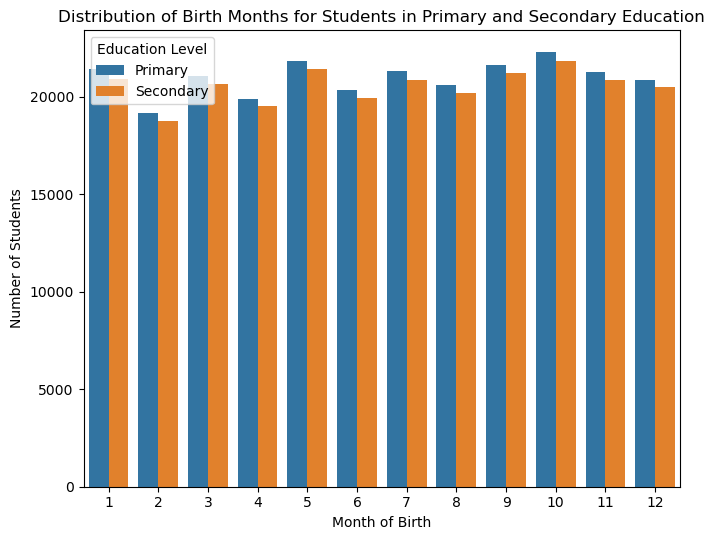

In [50]:
# ===============================
# 3. Plot 1: Distribution of Birth Months
# ===============================
df_birth_months = df_combined[['CODI_ALUMNE', 'MES_NAIXEMENT', 'snapshot']].drop_duplicates()

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(df_birth_months['MES_NAIXEMENT'], 
                                                  categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(7, 5.5))
sns.countplot(data=df_birth_months, x='MES_NAIXEMENT', hue='snapshot')
plt.title('Distribution of Birth Months for Students in Primary and Secondary Education')
plt.xlabel('Month of Birth')
plt.ylabel('Number of Students')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.tight_layout()
plt.show()

#### Mathematics Grades by Birth Month

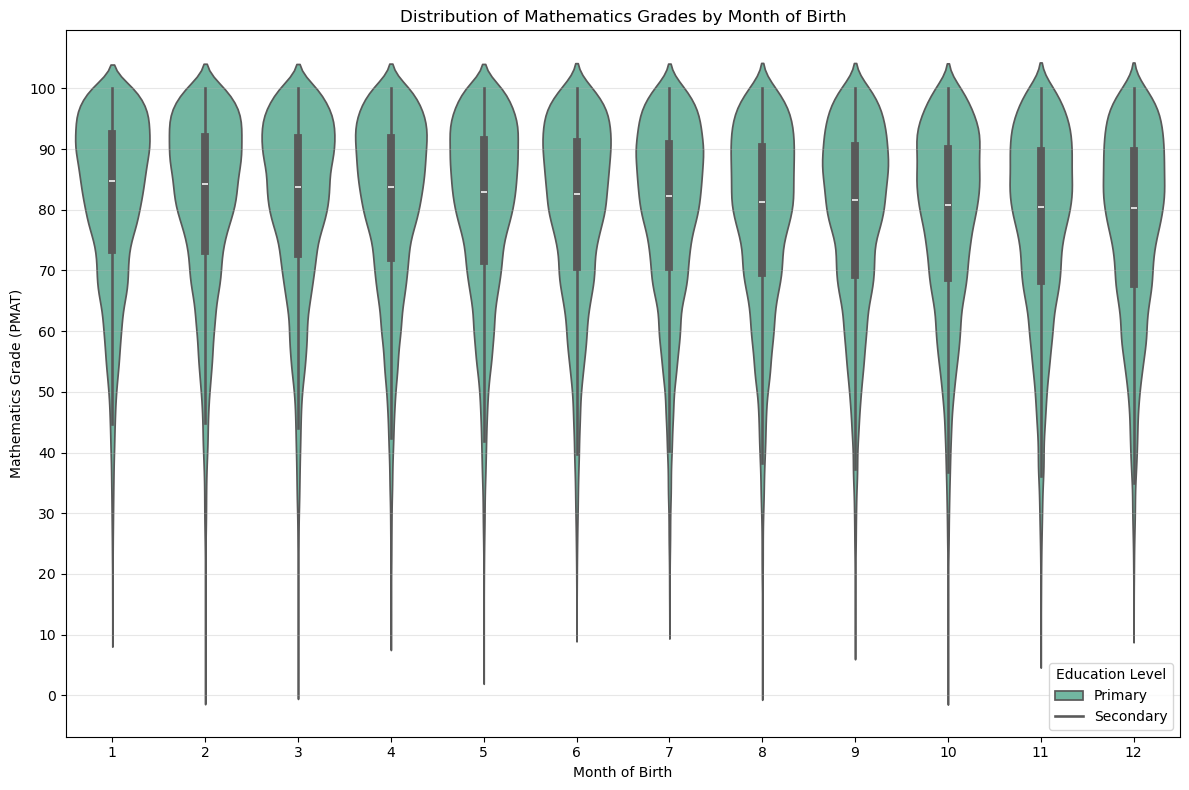

In [ ]:
# ===============================
# 4. Plot 2: Mathematics Grades by Birth Month (Violin Distribution)
# ===============================
df_math_grades = df_combined[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC', 'snapshot']].drop_duplicates(subset='CODI_ALUMNE')

# Order the months correctly, from 1 to 12
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(df_math_grades['MES_NAIXEMENT'], categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(12, 8))
sns.violinplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', 
               palette='Set2', split=True)

# Set y-axis ticks every 1 point
plt.yticks(range(0, 101, 10))

plt.title('Distribution of Mathematics Grades by Month of Birth')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



# Redo

#### Import and read data

In [ ]:
# Imports
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [62]:
# Check files in the Raw Data folder
os.listdir('../Data/Raw')


['Avaluacio_de_quart_dEducació_Secundaria_Obligatoria_20251111.csv',
 'Avaluació_de_sise_deducació_primaria_20251110.csv',
 'Plantilles_del_personal_docent_dels_centres_públics_i_serveis_educatius_20251111.csv']

In [64]:
# Load secondary education data
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])
df_S = pd.read_csv(csv_path)

# Load primary education data
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])
df_P = pd.read_csv(csv_path)


/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_20632/1460659640.py:3: DtypeWarning: Columns (3,6,10,11,12,13,14,16,18,19,20,21,22,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_S = pd.read_csv(csv_path)
/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_20632/1460659640.py:7: DtypeWarning: Columns (12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_P = pd.read_csv(csv_path)


In [67]:
# Display shapes
print(f"df_P shape: {df_P.shape}")
print(f"df_S shape: {df_S.shape}")


df_P shape: (963033, 32)
df_S shape: (778553, 36)


In [ ]:
# Find Matching students
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE'])
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']]

df_P_matching = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
df_S_matching = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P_matching.reset_index(drop=True, inplace=True)
df_S_matching.reset_index(drop=True, inplace=True)

#### Required columns for the study

In [70]:
# Filter columns to keep only required ones
# Required columns
required_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'GENERE', 'HÀBITAT',
    'MES_NAIXEMENT', 'NATURALESA', 'PANG', 'PANG_CO', 'PANG_EE',
    'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE',
    'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC'
]

# Extract only required columns
df_P_clean = df_P_matching[required_cols].copy()
df_S_clean = df_S_matching[required_cols].copy()

# Add snapshot identifier BEFORE grade conversion
df_P_clean['snapshot'] = 'Primària'
df_S_clean['snapshot'] = 'Secundaria'

# Combine into one dataframe
df_combined = pd.concat([df_P_clean, df_S_clean], ignore_index=True)

print(f"df_combined shape: {df_combined.shape}")
print(df_combined.head())



df_combined shape: (1190500, 24)
    ANY  ANY_NAIXEMENT   CODI_ALUMNE GENERE            HÀBITAT  MES_NAIXEMENT  \
0  2019         2007.0  1.863730e+10      H  De 10001 a 100000            8.0   
1  2019         2007.0  1.782432e+10      H  De 10001 a 100000            3.0   
2  2019         2007.0  1.781994e+10      D      Més de 100000            2.0   
3  2019         2007.0  1.781912e+10      H  De 10001 a 100000           11.0   
4  2019         2007.0  1.781798e+10      H      Més de 100000           11.0   

  NATURALESA   PANG PANG_CO PANG_EE  ... PCAT_CL PCAT_EE PFRAN PFRAN_CO  \
0     Privat  97,50  100,00   83,33  ...   86,36   61,11   NaN      NaN   
1     Públic  93,33   92,86  100,00  ...     NaN     NaN   NaN      NaN   
2     Públic  80,00   92,86   66,67  ...     NaN     NaN   NaN      NaN   
3     Privat  90,42  100,00   50,00  ...     NaN     NaN   NaN      NaN   
4     Públic  95,42  100,00   83,33  ...     NaN     NaN   NaN      NaN   

  PFRAN_EE   PMAT PMAT_CR PMA

#### Convert grades to numbers

In [71]:
# Grade conversion to real numeric values
def convert_grade_columns_to_numeric(df, prefix="P"):
    """
    Convert all columns starting with a given prefix (e.g. 'P')
    from strings with comma decimals to numeric floats.
    Non-convertible values become NaN.
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix)]
    for col in grade_cols:
        # Ensure string type first
        s = df[col].astype(str)
        # Replace comma with dot for decimal conversion
        s = s.str.replace(",", ".", regex=False)
        # Convert to numeric; invalid parsing becomes NaN
        df[col] = pd.to_numeric(s, errors="coerce")
    return grade_cols


In [74]:
# Convert all grade columns starting with 'P' to numeric
grade_cols_P = convert_grade_columns_to_numeric(df_combined, prefix="P")

print(f"Converted grade columns: {grade_cols_P}")
print(f"\ndf_combined after conversion:")
print(df_combined[grade_cols_P].head())
print(f"\nData types:")
print(df_combined[grade_cols_P].dtypes)


Converted grade columns: ['PANG', 'PANG_CO', 'PANG_EE', 'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC']

df_combined after conversion:
    PANG  PANG_CO  PANG_EE  PCAST  PCAST_CL  PCAST_EE  PCAT  PCAT_CL  PCAT_EE  \
0  97.50   100.00    83.33  65.48     68.18     61.11  67.9    86.36    61.11   
1  93.33    92.86   100.00    NaN       NaN       NaN   NaN      NaN      NaN   
2  80.00    92.86    66.67    NaN       NaN       NaN   NaN      NaN      NaN   
3  90.42   100.00    50.00  62.53     77.27     44.44   NaN      NaN      NaN   
4  95.42   100.00    83.33    NaN       NaN       NaN   NaN      NaN      NaN   

   PFRAN  PFRAN_CO  PFRAN_EE   PMAT  PMAT_CR  PMAT_EFM  PMAT_NC  
0    NaN       NaN       NaN  62.44    44.44     72.73    71.43  
1    NaN       NaN       NaN    NaN      NaN       NaN      NaN  
2    NaN       NaN       NaN    NaN      NaN       NaN      NaN  
3    NaN       NaN      

In [82]:
# Sepparate primary and secondary, and make a copy. Drop duplicate students!
df_primary = df_combined[df_combined['snapshot'] == 'Primària'].copy().drop_duplicates('CODI_ALUMNE')
df_secondary = df_combined[df_combined['snapshot'] == 'Secundaria'].copy().drop_duplicates('CODI_ALUMNE')

print(f"Primary education records: {len(df_primary)}")
print(f"Secondary education records: {len(df_secondary)}")


Primary education records: 251748
Secondary education records: 251748


In [83]:
df_primary.head()

,ANY,ANY_NAIXEMENT,CODI_ALUMNE,GENERE,HÀBITAT,MES_NAIXEMENT,NATURALESA,PANG,PANG_CO,PANG_EE,...,PCAT_CL,PCAT_EE,PFRAN,PFRAN_CO,PFRAN_EE,PMAT,PMAT_CR,PMAT_EFM,PMAT_NC,snapshot
0,2019,2007.0,1.863730e+10,H,De 10001 a 100000,8.0,Privat,97.50,100.00,83.33,...,86.36,61.11,NaN,NaN,NaN,62.44,44.44,72.73,71.43,Primària
1,2019,2007.0,1.782432e+10,H,De 10001 a 100000,3.0,Públic,93.33,92.86,100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Primària
2,2019,2007.0,1.781994e+10,D,Més de 100000,2.0,Públic,80.00,92.86,66.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Primària
3,2019,2007.0,1.781912e+10,H,De 10001 a 100000,11.0,Privat,90.42,100.00,50.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Primària
4,2019,2007.0,1.781798e+10,H,Més de 100000,11.0,Públic,95.42,100.00,83.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Primària


In [84]:
df_secondary.head()

,ANY,ANY_NAIXEMENT,CODI_ALUMNE,GENERE,HÀBITAT,MES_NAIXEMENT,NATURALESA,PANG,PANG_CO,PANG_EE,...,PCAT_CL,PCAT_EE,PFRAN,PFRAN_CO,PFRAN_EE,PMAT,PMAT_CR,PMAT_EFM,PMAT_NC,snapshot
700990,2023,2007.0,3.901524e+09,H,De 10001 a 100000,6.0,Privada,78.4,80.00,80.0,...,73.75,78.13,NaN,NaN,NaN,80.81,87.5,75.0,77.78,Secundaria
700991,2023,2007.0,3.903494e+09,H,De 10001 a 100000,9.0,Privada,74.0,80.00,60.0,...,70.11,59.38,NaN,NaN,NaN,66.06,75.0,50.0,77.78,Secundaria
700992,2023,2007.0,4.328916e+09,H,De 10001 a 100000,7.0,Privada,56.0,53.33,80.0,...,53.71,15.63,NaN,NaN,NaN,31.69,62.5,12.5,22.22,Secundaria
700993,2023,2007.0,3.901434e+09,H,De 10001 a 100000,5.0,Privada,88.8,93.33,80.0,...,90.15,87.50,NaN,NaN,NaN,90.56,100.0,75.0,77.78,Secundaria
700994,2023,2006.0,3.900118e+09,H,De 10001 a 100000,8.0,Privada,66.6,86.67,50.0,...,71.93,56.25,NaN,NaN,NaN,42.36,37.5,25.0,55.56,Secundaria


In [103]:
months_primary = df_primary.groupby('MES_NAIXEMENT')['PMAT']

In [104]:
months_primary.head()

0      62.44
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7      52.83
8        NaN
9        NaN
10       NaN
11     56.72
12     85.46
13       NaN
14       NaN
15     70.95
16       NaN
17       NaN
18     64.10
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29     57.76
30       NaN
31       NaN
32       NaN
33       NaN
34       NaN
35       NaN
36     70.53
37       NaN
38     71.57
39       NaN
40     82.61
41       NaN
42       NaN
43     76.58
44       NaN
45       NaN
46       NaN
48     49.31
49     79.10
50     90.79
52     85.13
54       NaN
55       NaN
56       NaN
57     97.86
58       NaN
65    100.00
68       NaN
72     83.01
75       NaN
Name: PMAT, dtype: float64

### Plot 1: Birth months distribution

df_combined shape: (1190500, 24)
MES_NAIXEMENT unique values: [ 8.  3.  2. 11.  9.  5.  1.  7.  4. 12. 10.  6. nan]
MES_NAIXEMENT dtype: float64
NaN count in MES_NAIXEMENT: 8104
After dropna: 1182396 rows


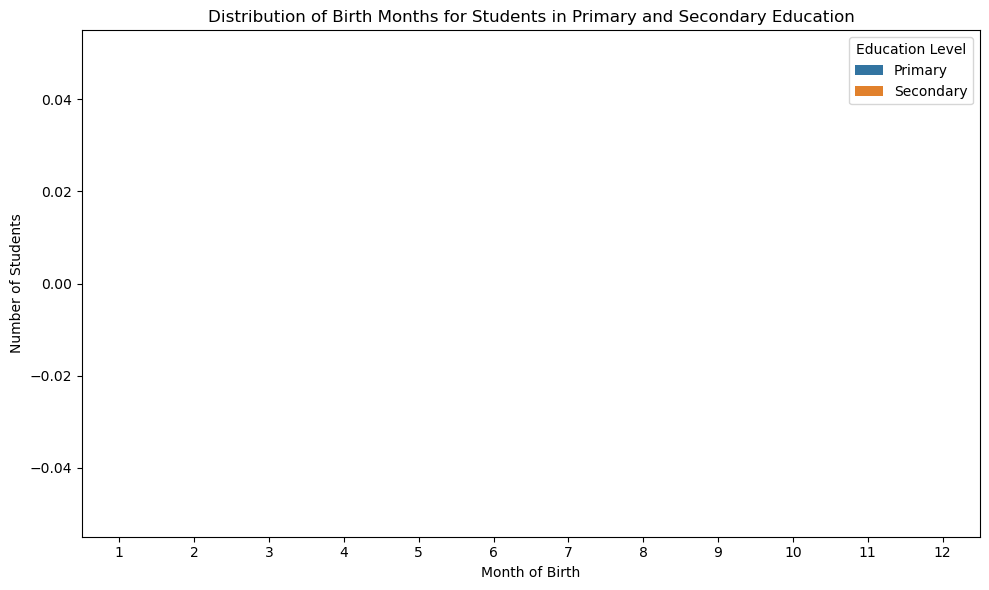

In [102]:
# ==============================
# PLOT 1: Birth Months Distribution (FIXED)
# ==============================

# First, let's check and debug
print(f"df_combined shape: {df_combined.shape}")
print(f"MES_NAIXEMENT unique values: {df_combined['MES_NAIXEMENT'].unique()}")
print(f"MES_NAIXEMENT dtype: {df_combined['MES_NAIXEMENT'].dtype}")
print(f"NaN count in MES_NAIXEMENT: {df_combined['MES_NAIXEMENT'].isna().sum()}")

# Filter out NaN values
df_birth_months = df_combined[['CODI_ALUMNE', 'MES_NAIXEMENT', 'snapshot']].dropna(subset=['MES_NAIXEMENT'])

print(f"After dropna: {len(df_birth_months)} rows")

# Convert to categorical and order months
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(
    df_birth_months['MES_NAIXEMENT'], 
    categories=[str(i) for i in range(1, 13)], 
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_birth_months, x='MES_NAIXEMENT', hue='snapshot')
plt.title('Distribution of Birth Months for Students in Primary and Secondary Education')
plt.xlabel('Month of Birth')
plt.ylabel('Number of Students')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.tight_layout()
plt.show()



### Mathematic grades per month

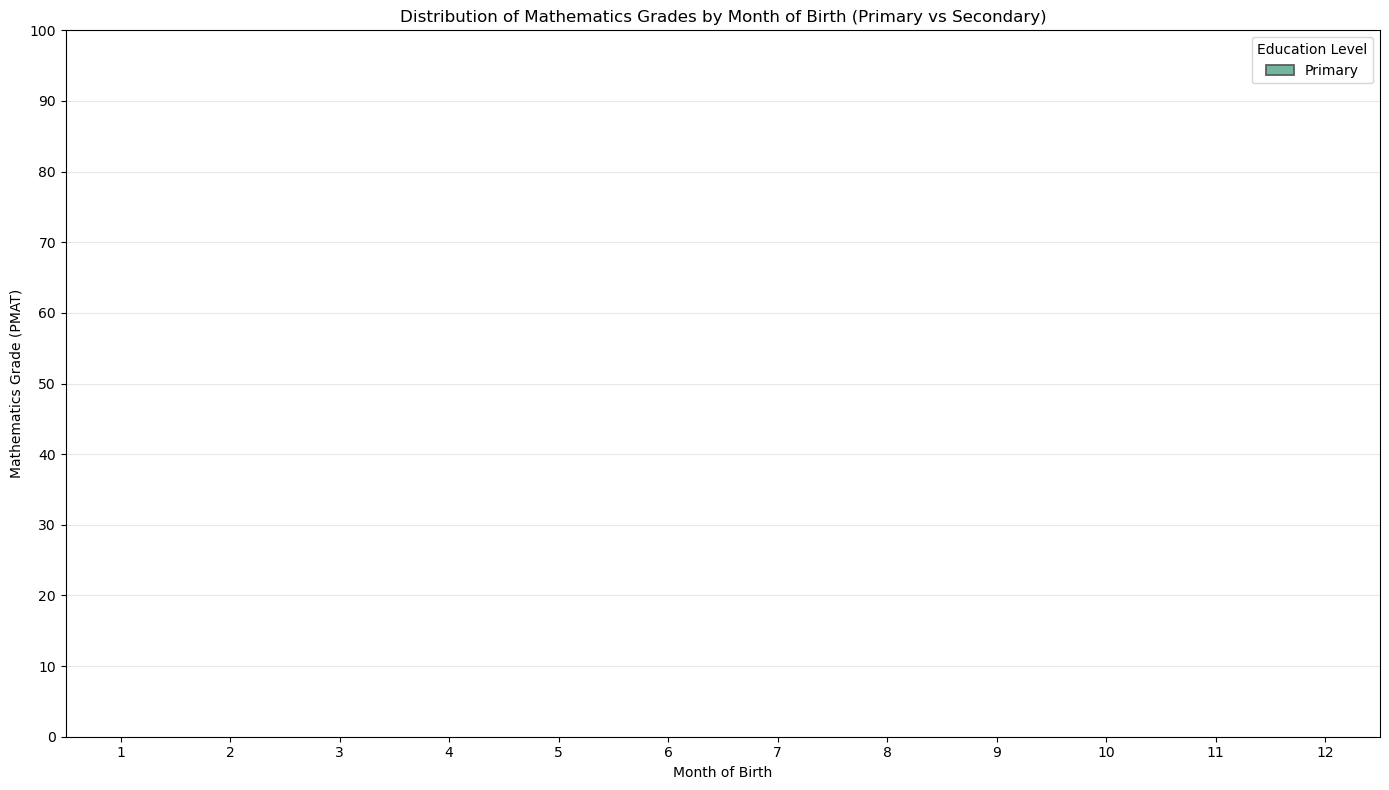

In [76]:
df_math_grades = df_combined[
    ['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT', 'snapshot']
].drop_duplicates(subset='CODI_ALUMNE')

# Order months correctly (1-12)
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(
    df_math_grades['MES_NAIXEMENT'], 
    categories=[str(i) for i in range(1, 13)], 
    ordered=True
)

plt.figure(figsize=(14, 8))
sns.violinplot(
    data=df_math_grades, 
    x='MES_NAIXEMENT', 
    y='PMAT', 
    hue='snapshot', 
    palette='Set2', 
    split=True
)

# Set y-axis ticks every 10 points
plt.yticks(range(0, 101, 10))

plt.title('Distribution of Mathematics Grades by Month of Birth (Primary vs Secondary)')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
